In [1]:
import os
import math
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 11})
import matplotlib.ticker as ticker
# PyTorch
import torch

In [2]:
cifar10_dictionary = np.load('CIFAR-10_ConvNeXt_Tiny_dictionary.npy', allow_pickle=True).item()
cifar10_nll_dictionary = np.load('CIFAR-10_ConvNeXt-Tiny_NLL_dictionary.npy', allow_pickle=True).item()
cifar10_clml_dictionary = np.load('CIFAR-10_ConvNeXt-Tiny_CLML_dictionary.npy', allow_pickle=True).item()
cifar10_clml_bma_dictionary = np.load('CIFAR-10_ConvNeXt-Tiny_CLML_BMA_dictionary.npy', allow_pickle=True).item()
flower102_dictionary = np.load('Flowers_102_ConvNeXt_Tiny_dictionary.npy', allow_pickle=True).item()
pet37_dictionary = np.load('Oxford-IIIT_Pet_ConvNeXt_Tiny_dictionary.npy', allow_pickle=True).item()
news4_dictionary = np.load('AG_News_BERT-base_dictionary.npy', allow_pickle=True).item()

In [3]:
cifar10_bo_df = pd.read_csv("CIFAR-10_ConvNeXt-Tiny_BO")
pet37_bo_df = pd.read_csv("Pet-37_ConvNeXt-Tiny_BO")
flower102_bo_df = pd.read_csv("Flower-102_ConvNeXt-Tiny_BO")
news4_bo_df = pd.read_csv("News-4_BERT-base_BO.csv")

In [4]:
cifar10_bo_grouped_df = cifar10_bo_df.groupby(['n', 'n_iter', 'random_state']).agg(lambda x: tuple(x))
columns = ['runtime', 'val_acc', 'test_acc']
for column in columns:
    cifar10_bo_grouped_df[f'{column}_mean'] = cifar10_bo_grouped_df[column].apply(lambda item: np.mean(item))
    cifar10_bo_grouped_df[f'{column}_std'] = cifar10_bo_grouped_df[column].apply(lambda item: np.std(item))
    cifar10_bo_grouped_df[f'{column}_min'] = cifar10_bo_grouped_df[column].apply(lambda item: np.min(item))
    cifar10_bo_grouped_df[f'{column}_max'] = cifar10_bo_grouped_df[column].apply(lambda item: np.max(item))
cifar10_bo_grouped_df = cifar10_bo_grouped_df.reset_index()
cifar10_bo_grouped_df.head()

,n,n_iter,random_state,alpha,beta,lr_0,runtime,seed,val_acc,val_nll,...,runtime_min,runtime_max,val_acc_mean,val_acc_std,val_acc_min,val_acc_max,test_acc_mean,test_acc_std,test_acc_min,test_acc_max
0,100.0,0.0,1001.0,"(0.0075894797620838, 1.7547413041177137e-06, 0...","(0.0006780776932355, 7.91075667332751e-06, 2.4...","(0.0023886297077207, 0.000504379633604, 0.0133...","(6941.181363582611, 6241.474300146103, 6164.70...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.6000000834465027, 0.7500001192092896, 0.650...","(1.2913535833358765, 1.03718364238739, 0.92717...",...,5864.111956,6941.181364,0.65,0.054772,0.60,0.75,0.70832,0.081145,0.6080,0.8095
1,100.0,0.0,2001.0,"(0.0075894797620838, 1.7547413041177137e-06, 0...","(0.0006780776932355, 7.91075667332751e-06, 2.4...","(0.0023886297077207, 0.000504379633604, 0.0133...","(5831.208561420441, 5869.264914035797, 5852.55...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.5, 0.4500000476837158, 0.6000000238418579, ...","(2.120349168777466, 1.9108734130859373, 1.6693...",...,5831.208561,5869.264914,0.53,0.050990,0.45,0.60,0.73098,0.067555,0.6548,0.8151
2,100.0,0.0,3001.0,"(0.0075894797620838, 1.7547413041177137e-06, 0...","(0.0006780776932355, 7.91075667332751e-06, 2.4...","(0.0023886297077207, 0.000504379633604, 0.0133...","(5795.697523593903, 5845.676057815552, 5973.08...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.7500000596046448, 0.7000000476837158, 0.800...","(0.8124095797538757, 0.8094868659973145, 0.338...",...,5795.697524,6167.409505,0.77,0.050990,0.70,0.85,0.76594,0.044268,0.7173,0.8176
3,100.0,1.0,1001.0,"(1.1021585497520294e-06, 0.0034424767798646, 1...","(1e-06, 0.01, 0.0084242641625553, 0.01, 1e-06)","(0.1, 0.0640999034994377, 0.0001, 0.0001, 0.1)","(9627.154016256332, 9107.608215808868, 8834.28...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.4000000059604645, 0.7500001192092896, 0.650...","(3.1932857036590576, 0.9973223805427552, 1.216...",...,8473.141821,9627.154016,0.62,0.116619,0.40,0.75,0.73122,0.074365,0.6080,0.8095
4,100.0,1.0,2001.0,"(1.1021585497520294e-06, 0.0034424767798646, 1...","(1e-06, 0.01, 0.0084242641625553, 0.01, 1e-06)","(0.1, 0.0640999034994377, 0.0001, 0.0001, 0.1)","(8437.144790887833, 8504.659116268158, 8791.42...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.550000011920929, 0.6000000238418579, 0.5500...","(3.493883848190308, 2.375278949737549, 1.45739...",...,8437.144791,9772.025777,0.59,0.058310,0.55,0.70,0.66670,0.022333,0.6500,0.7090


In [5]:
pet37_bo_grouped_df = pet37_bo_df.groupby(['n', 'n_iter', 'random_state']).agg(lambda x: tuple(x))
columns = ['runtime', 'val_acc', 'test_acc']
for column in columns:
    pet37_bo_grouped_df[f'{column}_mean'] = pet37_bo_grouped_df[column].apply(lambda item: np.mean(item))
    pet37_bo_grouped_df[f'{column}_std'] = pet37_bo_grouped_df[column].apply(lambda item: np.std(item))
    pet37_bo_grouped_df[f'{column}_min'] = pet37_bo_grouped_df[column].apply(lambda item: np.min(item))
    pet37_bo_grouped_df[f'{column}_max'] = pet37_bo_grouped_df[column].apply(lambda item: np.max(item))
pet37_bo_grouped_df = pet37_bo_grouped_df.reset_index()
pet37_bo_grouped_df.head()

,n,n_iter,random_state,alpha,beta,lr_0,runtime,seed,val_acc,val_nll,...,runtime_min,runtime_max,val_acc_mean,val_acc_std,val_acc_min,val_acc_max,test_acc_mean,test_acc_std,test_acc_min,test_acc_max
0,370.0,0.0,1001.0,"(0.0075894797620838, 1.7547413041177137e-06, 0...","(0.0006780776932355, 7.91075667332751e-06, 2.4...","(0.0023886297077207, 0.000504379633604, 0.0133...","(7622.572840213776, 7122.802211046219, 7158.62...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.9324324727058412, 0.9594594836235046, 0.959...","(0.1656830459833145, 0.2356095165014267, 0.153...",...,7122.802211,7622.572840,0.932432,0.025640,0.891892,0.959459,0.874552,0.020319,0.842854,0.896920
1,370.0,0.0,2001.0,"(0.0075894797620838, 1.7547413041177137e-06, 0...","(0.0006780776932355, 7.91075667332751e-06, 2.4...","(0.0023886297077207, 0.000504379633604, 0.0133...","(7721.646580457687, 7801.981445074081, 7882.98...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.9459459781646729, 0.8918918967247009, 0.932...","(0.2301973104476928, 0.3530605733394623, 0.188...",...,7222.425373,7882.985600,0.908108,0.046342,0.824324,0.945946,0.870448,0.018782,0.835356,0.887275
2,370.0,0.0,3001.0,"(0.0075894797620838, 1.7547413041177137e-06, 0...","(0.0006780776932355, 7.91075667332751e-06, 2.4...","(0.0023886297077207, 0.000504379633604, 0.0133...","(7811.310105323791, 7195.052761554718, 7175.65...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.8783783912658691, 0.8378378748893738, 0.878...","(0.3388819694519043, 0.4188233613967895, 0.291...",...,7146.802203,7811.310105,0.856757,0.018331,0.837838,0.878378,0.885523,0.023112,0.843518,0.905073
3,370.0,1.0,1001.0,"(1.1021585497520294e-06, 0.0034424767798646, 1...","(1e-06, 0.01, 0.0084242641625553, 0.01, 1e-06)","(0.1, 0.0640999034994377, 0.0001, 0.0001, 0.1)","(11848.482882261276, 11386.544362783432, 11434...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.8918919563293457, 0.8648648858070374, 0.864...","(0.2710461020469665, 0.5444959402084351, 1.453...",...,10827.781043,11848.482882,0.881081,0.021622,0.864865,0.918919,0.887760,0.016533,0.859398,0.908895
4,370.0,1.0,2001.0,"(1.1021585497520294e-06, 0.0034424767798646, 1...","(1e-06, 0.01, 0.0084242641625553, 0.01, 1e-06)","(0.1, 0.0640999034994377, 0.0001, 0.0001, 0.1)","(10850.8718791008, 11410.697837591171, 11602.5...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.9054054617881776, 0.8918918967247009, 0.797...","(0.2215731143951416, 0.4245591163635254, 1.704...",...,10850.871879,11602.595199,0.870270,0.063729,0.797297,0.959459,0.879771,0.010172,0.867378,0.891796


In [6]:
flower102_bo_grouped_df = flower102_bo_df.groupby(['n', 'n_iter', 'random_state']).agg(lambda x: tuple(x))
columns = ['runtime', 'val_acc', 'test_acc']
for column in columns:
    flower102_bo_grouped_df[f'{column}_mean'] = flower102_bo_grouped_df[column].apply(lambda item: np.mean(item))
    flower102_bo_grouped_df[f'{column}_std'] = flower102_bo_grouped_df[column].apply(lambda item: np.std(item))
    flower102_bo_grouped_df[f'{column}_min'] = flower102_bo_grouped_df[column].apply(lambda item: np.min(item))
    flower102_bo_grouped_df[f'{column}_max'] = flower102_bo_grouped_df[column].apply(lambda item: np.max(item))
flower102_bo_grouped_df = flower102_bo_grouped_df.reset_index()
flower102_bo_grouped_df.head()

,n,n_iter,random_state,alpha,beta,lr_0,runtime,seed,val_acc,val_nll,...,runtime_min,runtime_max,val_acc_mean,val_acc_std,val_acc_min,val_acc_max,test_acc_mean,test_acc_std,test_acc_min,test_acc_max
0,510.0,0.0,1001.0,"(0.0075894797620838, 1.7547413041177137e-06, 0...","(0.0006780776932355, 7.91075667332751e-06, 2.4...","(0.0023886297077207, 0.000504379633604, 0.0133...","(7108.617203474045, 7252.8706176280975, 7190.2...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.7941176891326904, 0.7647058963775635, 0.774...","(0.9448467493057252, 1.78338623046875, 0.87129...",...,7108.617203,7252.870618,0.723529,0.138287,0.450980,0.833333,0.777771,0.136613,0.520541,0.895192
1,510.0,0.0,2001.0,"(0.0075894797620838, 1.7547413041177137e-06, 0...","(0.0006780776932355, 7.91075667332751e-06, 2.4...","(0.0023886297077207, 0.000504379633604, 0.0133...","(7101.707026004791, 7129.543971776962, 9005.38...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.8431373238563538, 0.7450981140136719, 0.862...","(0.7512351274490356, 1.6562025547027588, 0.564...",...,7101.707026,9005.380013,0.752941,0.167575,0.431373,0.882353,0.793494,0.126499,0.549014,0.887579
2,510.0,0.0,3001.0,"(0.0075894797620838, 1.7547413041177137e-06, 0...","(0.0006780776932355, 7.91075667332751e-06, 2.4...","(0.0023886297077207, 0.000504379633604, 0.0133...","(7157.395022392273, 7327.174964904785, 7718.32...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.774509847164154, 0.6666667461395264, 0.8235...","(1.0340112447738647, 2.055185556411743, 0.8645...",...,7157.395022,7795.830989,0.707843,0.156544,0.421569,0.852941,0.725269,0.171297,0.400670,0.857293
3,510.0,1.0,1001.0,"(1.1021585497520294e-06, 0.0034424767798646, 1...","(1e-06, 0.01, 0.0084242641625553, 0.01, 1e-06)","(0.1, 0.0640999034994377, 0.0001, 0.0001, 0.1)","(10784.78758263588, 11602.91801071167, 10902.1...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.6666666865348816, 0.6764706373214722, 0.343...","(1.4888240098953247, 1.610375165939331, 3.7572...",...,10784.787583,13100.098206,0.560784,0.181666,0.343137,0.774510,0.834107,0.051866,0.747789,0.895192
4,510.0,1.0,2001.0,"(1.1021585497520294e-06, 0.0034424767798646, 1...","(1e-06, 0.01, 0.0084242641625553, 0.01, 1e-06)","(0.1, 0.0640999034994377, 0.0001, 0.0001, 0.1)","(12576.377890825272, 11507.13664674759, 12704....","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.7450981140136719, 0.686274528503418, 0.3137...","(1.138723611831665, 1.167037844657898, 3.75482...",...,11375.399813,12704.744136,0.568627,0.210453,0.313726,0.784314,0.848778,0.048210,0.754772,0.887579


In [7]:
news4_bo_grouped_df = news4_bo_df.groupby(['n', 'n_iter', 'random_state']).agg(lambda x: tuple(x))
columns = ['runtime', 'val_acc', 'test_acc']
for column in columns:
    news4_bo_grouped_df[f'{column}_mean'] = news4_bo_grouped_df[column].apply(lambda item: np.mean(item))
    news4_bo_grouped_df[f'{column}_std'] = news4_bo_grouped_df[column].apply(lambda item: np.std(item))
    news4_bo_grouped_df[f'{column}_min'] = news4_bo_grouped_df[column].apply(lambda item: np.min(item))
    news4_bo_grouped_df[f'{column}_max'] = news4_bo_grouped_df[column].apply(lambda item: np.max(item))
news4_bo_grouped_df = news4_bo_grouped_df.reset_index()
news4_bo_grouped_df.head()

,n,n_iter,random_state,alpha,beta,lr_0,runtime,seed,val_acc,val_nll,...,runtime_min,runtime_max,val_acc_mean,val_acc_std,val_acc_min,val_acc_max,test_acc_mean,test_acc_std,test_acc_min,test_acc_max
0,40000.0,0.0,1001.0,"(0.0075894797620838, 1.7547413041177137e-06, 0...","(0.0006780776932355, 7.91075667332751e-06, 2.4...","(0.0023886297077207, 0.000504379633604, 0.0133...","(14682.265820264816, 14728.69370174408, 14783....","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.9348750114440918, 0.9237499833106996, 0.936...","(0.0200037903652992, 0.0205080923270434, 0.034...",...,14601.063778,14946.744869,0.928112,0.010224,0.906125,0.936375,0.857711,0.202833,0.250000,0.935395
1,40000.0,0.0,2001.0,"(0.0075894797620838, 1.7547413041177137e-06, 0...","(0.0006780776932355, 7.91075667332751e-06, 2.4...","(0.0023886297077207, 0.000504379633604, 0.0133...","(14767.876569986343, 14750.065286159515, 14795...","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.927625060081482, 0.9173749685287476, 0.9292...","(0.0231607628126512, 0.0234374159560538, 0.037...",...,14432.496850,14862.465971,0.921800,0.009904,0.902125,0.931750,0.925118,0.011086,0.903421,0.934737
2,40000.0,0.0,3001.0,"(0.0075894797620838, 1.7547413041177137e-06, 0...","(0.0006780776932355, 7.91075667332751e-06, 2.4...","(0.0023886297077207, 0.000504379633604, 0.0133...","(14636.859175682068, 14973.604129076004, 14578...","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.9358749985694884, 0.9235000014305116, 0.934...","(0.0204124147051479, 0.0216265652677975, 0.033...",...,14578.767353,14973.604129,0.927812,0.009161,0.909125,0.935875,0.857382,0.202706,0.250000,0.935526
3,40000.0,1.0,1001.0,"(1.1021585497520294e-06, 0.0034424767798646, 1...","(1e-06, 0.01, 0.0084242641625553, 0.01, 1e-06,...","(0.1, 0.0640999034994377, 0.0001, 0.0001, 0.1,...","(22301.09246206284, 22457.66979908943, 22481.5...","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.25, 0.9338749647140504, 0.9021250009536744,...","(0.129965796366334, 0.0258485580599371, 0.0263...",...,22261.901010,22543.427379,0.716325,0.305574,0.250000,0.935000,0.915355,0.015057,0.898816,0.936053
4,40000.0,1.0,2001.0,"(1.1021585497520294e-06, 0.0034424767798646, 1...","(1e-06, 0.01, 0.0084242641625553, 0.01, 1e-06,...","(0.1, 0.0640999034994377, 0.0001, 0.0001, 0.1,...","(22278.569452285767, 22429.214097499847, 22451...","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.25, 0.9320000410079956, 0.8962500095367432,...","(0.1299674031436442, 0.0282268907722755, 0.029...",...,21953.384858,22473.444976,0.713425,0.303769,0.250000,0.933750,0.911579,0.013517,0.897632,0.931842


In [8]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_ConvNeXt-Tiny_diagEF'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
method = 'l2-sp'
ns = [100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_lml', 'test_acc', 'test_nll']
cifar10_laplace_tuned_df = pd.DataFrame(columns=columns)

for lr_0, n, random_state in itertools.product(lr_0s, ns, random_states):
    model_name = f'{method}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_lml.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    cifar10_laplace_tuned_df.loc[len(cifar10_laplace_tuned_df)] = row
    
min_indices = cifar10_laplace_tuned_df.groupby(['method', 'n', 'random_state'])['train_lml'].idxmax()
cifar10_laplace_retrained_df = cifar10_laplace_tuned_df.loc[min_indices]
cifar10_laplace_retrained_df['total_time'] = cifar10_laplace_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

AttributeError: 'DataFrame' object has no attribute 'val_or_test_acc'

In [ ]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_ConvNeXt_Tiny_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
cifar10_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa=1.0_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    cifar10_elbo_tuned_df.loc[len(cifar10_elbo_tuned_df)] = row
    
min_indices = cifar10_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
cifar10_elbo_retrained_df = cifar10_elbo_tuned_df.loc[min_indices]
cifar10_elbo_retrained_df['total_time'] = cifar10_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [ ]:
#d = 23528522
#d = 85806346
d = 27827818
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_ConvNeXt_Tiny_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
cifar10_deelbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa={d/n}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    cifar10_deelbo_tuned_df.loc[len(cifar10_deelbo_tuned_df)] = row
    
min_indices = cifar10_deelbo_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
cifar10_deelbo_retrained_df = cifar10_deelbo_tuned_df.loc[min_indices]
cifar10_deelbo_retrained_df['total_time'] = cifar10_deelbo_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [ ]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Flowers_102_diagEF'
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Flower-102_ConvNeXt-Tiny_diagEF'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
method = 'l2-sp'
ns = [510, 1020]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_lml', 'test_acc', 'test_nll']
flower102_laplace_tuned_df = pd.DataFrame(columns=columns)

for lr_0, n, random_state in itertools.product(lr_0s, ns, random_states):
    model_name = f'{method}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_lml.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    flower102_laplace_tuned_df.loc[len(flower102_laplace_tuned_df)] = row
    
min_indices = flower102_laplace_tuned_df.groupby(['method', 'n', 'random_state'])['train_lml'].idxmax()
flower102_laplace_retrained_df = flower102_laplace_tuned_df.loc[min_indices]
flower102_laplace_retrained_df['total_time'] = flower102_laplace_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [9]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Flowers_102_ConvNeXt_Tiny_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [510, 1020]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
flower102_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa=1.0_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    flower102_elbo_tuned_df.loc[len(flower102_elbo_tuned_df)] = row
    
min_indices = flower102_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
flower102_elbo_retrained_df = flower102_elbo_tuned_df.loc[min_indices]
flower102_elbo_retrained_df['total_time'] = flower102_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [10]:
#d = 23717030
#d = 85877094
d = 27898566
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Flowers_102_ConvNeXt_Tiny_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [510, 1020]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
flower102_deelbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa={d/n}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    flower102_deelbo_tuned_df.loc[len(flower102_deelbo_tuned_df)] = row
    
min_indices = flower102_deelbo_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
flower102_deelbo_retrained_df = flower102_deelbo_tuned_df.loc[min_indices]
flower102_deelbo_retrained_df['total_time'] = flower102_deelbo_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [11]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Oxford-IIIT_Pet_diagEF'
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Pet-37_ConvNeXt-Tiny_diagEF'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
method = 'l2-sp'
ns = [370, 3441]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_lml', 'test_acc', 'test_nll']
pet37_laplace_tuned_df = pd.DataFrame(columns=columns)

for lr_0, n, random_state in itertools.product(lr_0s, ns, random_states):
    model_name = f'{method}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_lml.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    pet37_laplace_tuned_df.loc[len(pet37_laplace_tuned_df)] = row
    
min_indices = pet37_laplace_tuned_df.groupby(['method', 'n', 'random_state'])['train_lml'].idxmax()
pet37_laplace_retrained_df = pet37_laplace_tuned_df.loc[min_indices]
pet37_laplace_retrained_df['total_time'] = pet37_laplace_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [12]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Oxford-IIIT_Pet_ConvNeXt_Tiny_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [370, 3441]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
pet37_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa=1.0_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    pet37_elbo_tuned_df.loc[len(pet37_elbo_tuned_df)] = row
    
min_indices = pet37_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
pet37_elbo_retrained_df = pet37_elbo_tuned_df.loc[min_indices]
pet37_elbo_retrained_df['total_time'] = pet37_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [13]:
#d = 23583845
#d = 85827109
d = 27848581
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Oxford-IIIT_Pet_ConvNeXt_Tiny_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [370, 3441]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
pet37_deelbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa={d/n}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    pet37_deelbo_tuned_df.loc[len(pet37_deelbo_tuned_df)] = row
    
min_indices = pet37_deelbo_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
pet37_deelbo_retrained_df = pet37_deelbo_tuned_df.loc[min_indices]
pet37_deelbo_retrained_df['total_time'] = pet37_deelbo_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [14]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_AG_News_diagEF_SGD'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
criterion = 'l2-sp'
ns = [40, 400, 4_000, 40_000, 120_000]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
news4_laplace_tuned_df = pd.DataFrame(columns=columns)

for lr_0, n, random_state in itertools.product(lr_0s, ns, random_states):
    model_name = f'{criterion}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    news4_laplace_tuned_df.loc[len(news4_laplace_tuned_df)] = row
    
min_indices = news4_laplace_tuned_df.groupby(['criterion', 'n', 'random_state'])['train_loss'].idxmin()
news4_laplace_retrained_df = news4_laplace_tuned_df.loc[min_indices]
news4_laplace_retrained_df['total_time'] = news4_laplace_tuned_df.groupby(['criterion', 'n', 'random_state'])['runtime'].sum().values   

In [15]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_AG_News_VI_SGD'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
criterion = 'l2-sp'
ns = [40, 400, 4_000, 40_000, 120_000]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
news4_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, n, random_state in itertools.product(lr_0s, ns, random_states):
    model_name = f'{criterion}_kappa=1.0_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    news4_elbo_tuned_df.loc[len(news4_elbo_tuned_df)] = row
    
min_indices = news4_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['train_loss'].idxmin()
news4_elbo_retrained_df = news4_elbo_tuned_df.loc[min_indices]
news4_elbo_retrained_df['total_time'] = news4_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['runtime'].sum().values   

In [16]:
d = 109485316
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_AG_News_VI_SGD'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
criterion = 'l2-sp'
ns = [40, 400, 4_000, 40_000, 120_000]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
news4_de_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, n, random_state in itertools.product(lr_0s, ns, random_states):
    model_name = f'{criterion}_kappa={d/n}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    news4_de_elbo_tuned_df.loc[len(news4_de_elbo_tuned_df)] = row
    
min_indices = news4_de_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['train_loss'].idxmin()
news4_de_elbo_retrained_df = news4_de_elbo_tuned_df.loc[min_indices]
news4_de_elbo_retrained_df['total_time'] = news4_de_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['runtime'].sum().values   

In [17]:
def plot_dictionary(ax, bootstrap_dictionary, n, random_states, color='#1F77B4', markers=['o', '^', 's']):
    for index, random_state in enumerate(random_states):
        x = bootstrap_dictionary[n][random_state][:,:,:,0].mean(axis=(0,2,))
        y = bootstrap_dictionary[n][random_state][:,:,:,1].mean(axis=(0,2,))
        lower_x, upper_x = np.percentile(bootstrap_dictionary[n][random_state][:,:,:,0].mean(axis=(2,)), [2.5, 97.5], axis=(0,))
        lower_y, upper_y = np.percentile(bootstrap_dictionary[n][random_state][:,:,:,1].mean(axis=(2,)), [2.5, 97.5], axis=(0,))
        ax.scatter(x[-1]/3600, y[-1], color=color, marker=markers[index], zorder=3)
        ax.plot(x/3600, y, color=color, zorder=2)
        ax.fill_between(x/3600, lower_y, upper_y, alpha=0.1, color=color, zorder=2)

NameError: name 'cifar10_laplace_retrained_df' is not defined

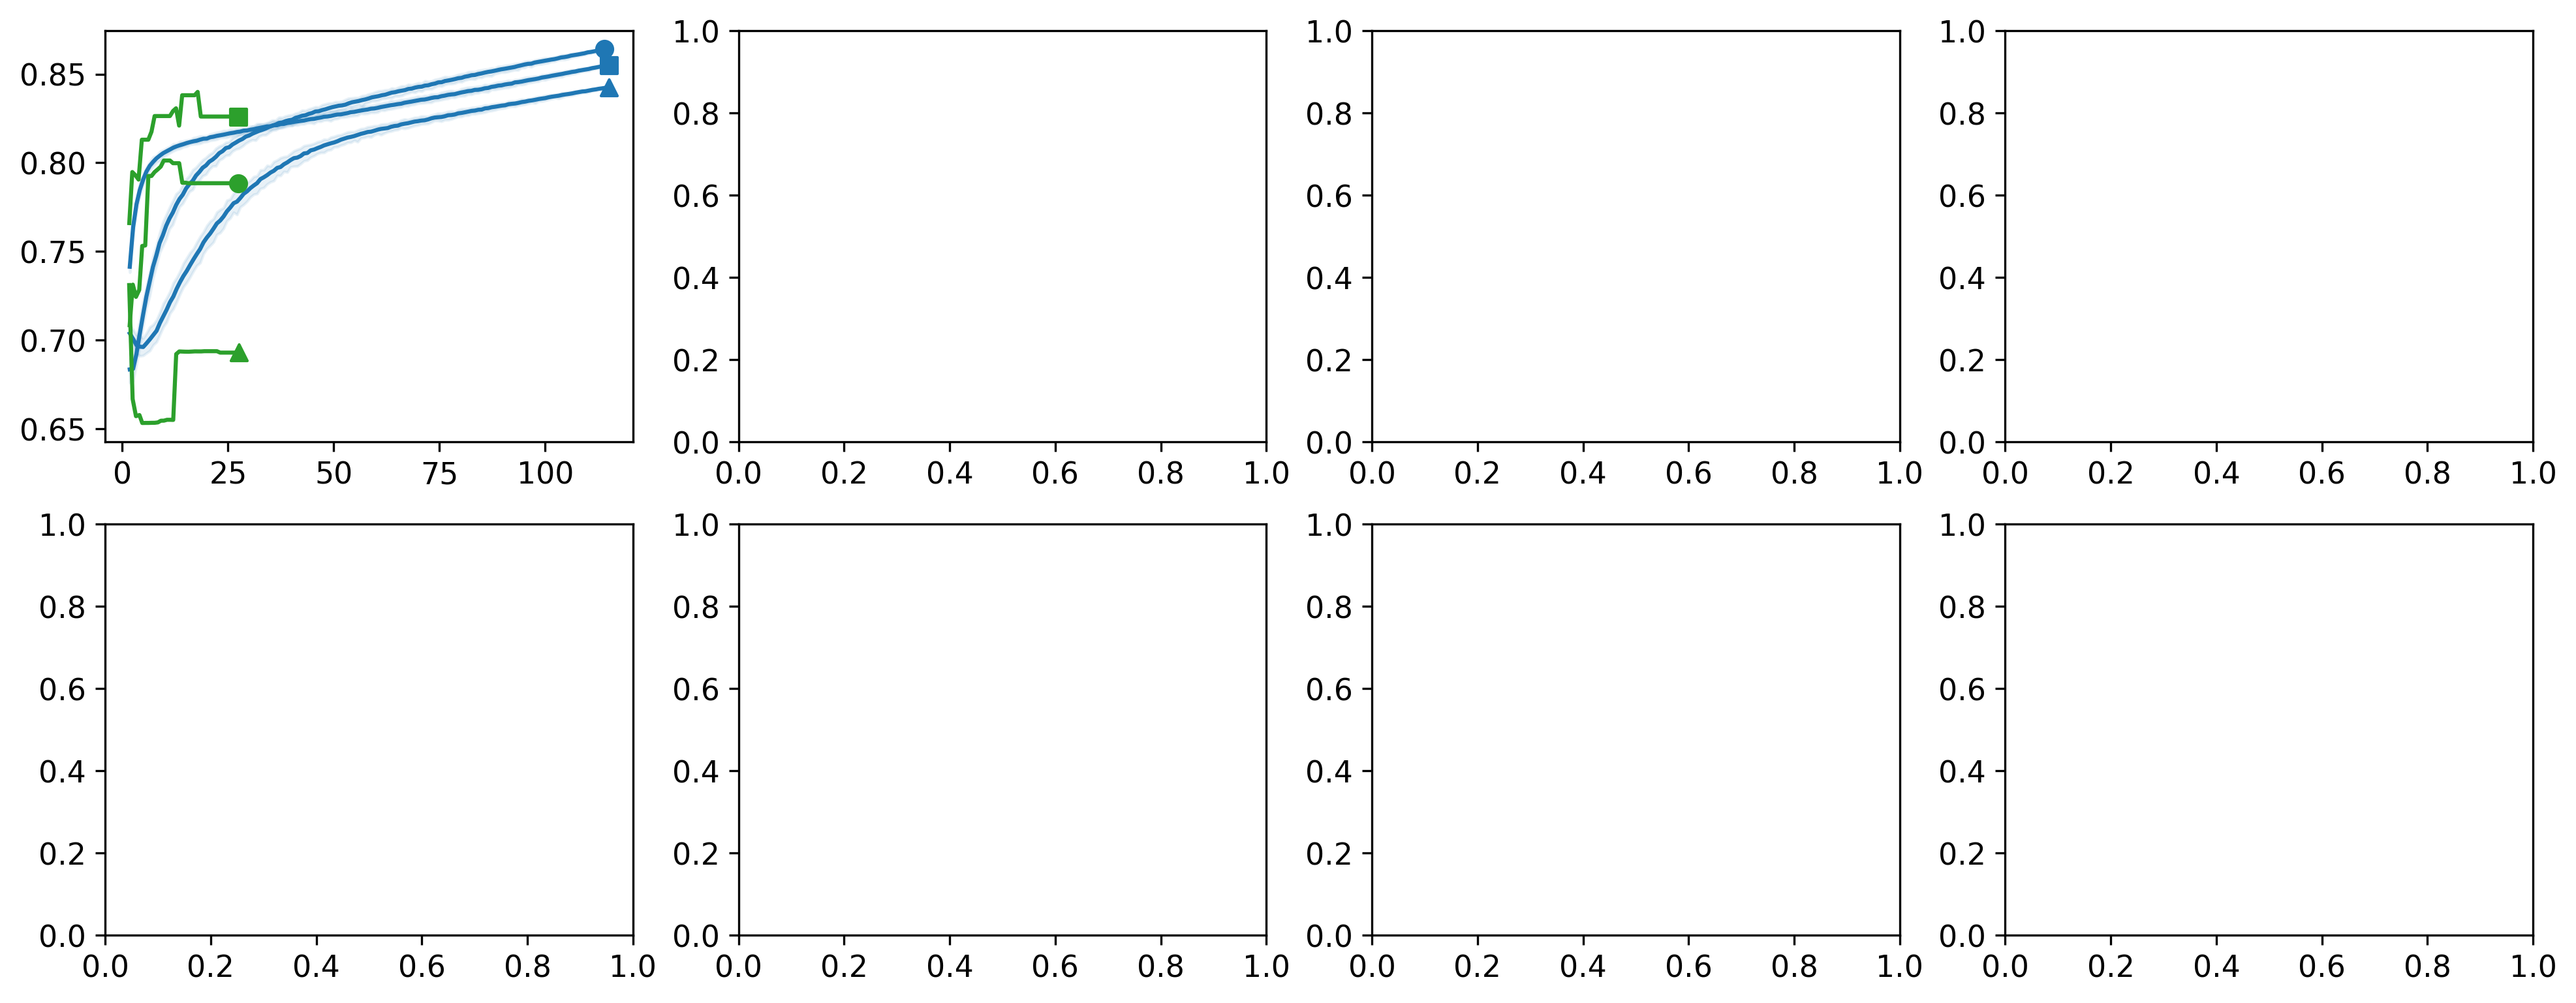

In [18]:
def break_axes(ax):
    d = 0.015
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    #ax.plot((-d, +d), (0.525 - d, 0.525 + d), **kwargs)
    #ax.plot((-d, +d), (0.475 - d, 0.475 + d), **kwargs)
    ax.plot((-d, +d), (0.275 - d, 0.275 + d), **kwargs)
    ax.plot((-d, +d), (0.225 - d, 0.225 + d), **kwargs)
    
def decorate_ax(ax, title):
    ax.set_title(title)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Test accuracy')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xscale('log', base=2)
    ax_xticks = ax.get_xticks()
    ax.set_xticks([int(ax_xtick) for ax_xtick in ax_xticks[2:-2]], [int(ax_xtick) for ax_xtick in ax_xticks[2:-2]])
    ax.grid()
    
def decorate_hidden_ax(ax, title):
    ax.set_title(title)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Test accuracy')
    ax.spines[['bottom', 'top', 'left', 'right']].set_visible(False)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax.tick_params(axis='y', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    
def decorate_broken_axes(ax1, ax2):
    
    ax1.spines[['bottom', 'top', 'right']].set_visible(False)
    ax2.spines[['right', 'top']].set_visible(False)
        
    ax1.set_xscale('log', base=2)
    ax2.set_xscale('log', base=2)
    ax1_xlim = ax1.get_xlim()
    ax1_xticks = ax1.get_xticks()
    ax1.set_xticks([int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]], [int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]])
    ax1.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax2.set_xlim(ax1_xlim)
    ax2.set_xticks([int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]], [int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]])
    
    ax1_distance = (ax1.get_ylim()[1] - ax1.get_ylim()[0])/3
    ax2_mean = sum(ax2.get_ylim())/2
    ax2_distance = [max(0.0, ax2_mean - (ax1_distance/2)), max(ax2_mean + (ax1_distance/2) - (ax2_mean - (ax1_distance/2)), ax2_mean + (ax1_distance/2))]
    ax2.scatter(4*np.ones_like(ax2_distance), ax2_distance, color='#FFFFFF')
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(round(ax1.get_yticks()[-1] - ax1.get_yticks()[-2], 3)))
    if len(ax2.get_yticks()) < 3 or len(ax2.get_yticks()) > 5:
        ax2.yaxis.set_major_locator(ticker.AutoLocator())
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    ax1.grid()
    ax2.grid()
    
    ax2.margins(x=0.05, y=0.15)

    
markers = ['o', '^', 's']
    
ncols, nrows = 4, 2
fig, axs = plt.subplots(dpi=300, figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

# Plot 1
plot_dictionary(axs[0,0], cifar10_dictionary, 100, [1001, 2001, 3001])
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = cifar10_bo_grouped_df[(cifar10_bo_grouped_df.n==100)&(cifar10_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[0,0].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[0,0].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
#plot_dictionary(axs[0,0], cifar10_nll_dictionary, 100, [1001, 2001, 3001])
#plot_dictionary(axs[0,0], cifar10_clml_dictionary, 100, [1001, 2001, 3001], color="#17BECF")
for index, (time, acc) in enumerate(zip(cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==100].total_time.values/3600, cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==100].test_acc.values)):
    axs[0,0].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
plot_dictionary(axs[0,0], cifar10_clml_bma_dictionary, 100, [1001, 2001, 3001], color="#17BECF")
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==100].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==100].test_acc.values)):
    axs[0,0].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_deelbo_retrained_df[cifar10_deelbo_retrained_df.n==100].total_time.values/3600, cifar10_deelbo_retrained_df[cifar10_deelbo_retrained_df.n==100].test_acc.values)):
    axs[0,0].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

decorate_ax(axs[0,0], r'CIFAR-10 $N=100$ (ConvNeXt-Tiny)')

# Plot 2
decorate_hidden_ax(axs[0,1], r'CIFAR-10 $N=1000$ (ConvNeXt-Tiny)')

ins2_top = axs[0,1].inset_axes([0.0, 0.275, 1.0, 0.725], zorder=1)
ins2_bottom = axs[0,1].inset_axes([0.0, 0.0, 1.0, 0.225], zorder=1)

plot_dictionary(ins2_top, cifar10_dictionary, 1000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==1000].total_time.values/3600, cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==1000].test_acc.values)):
    ins2_top.scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==1000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==1000].test_acc.values)):
    ins2_bottom.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_deelbo_retrained_df[cifar10_deelbo_retrained_df.n==1000].total_time.values/3600, cifar10_deelbo_retrained_df[cifar10_deelbo_retrained_df.n==1000].test_acc.values)):
    ins2_top.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = cifar10_bo_grouped_df[(cifar10_bo_grouped_df.n==1000)&(cifar10_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    ins2_top.scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    ins2_top.plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)

break_axes(axs[0,1])
decorate_broken_axes(ins2_top, ins2_bottom)

# Plot 3
plot_dictionary(axs[0,2], news4_dictionary, 40000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(news4_elbo_retrained_df[news4_elbo_retrained_df.n==40000].total_time.values/3600, news4_elbo_retrained_df[news4_elbo_retrained_df.n==40000].test_acc.values)):
    axs[0,2].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_laplace_retrained_df[news4_laplace_retrained_df.n==40000].total_time.values/3600, news4_laplace_retrained_df[news4_laplace_retrained_df.n==40000].test_acc.values)):
    axs[0,2].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==40000].total_time.values/3600, news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==40000].test_acc.values)):
    axs[0,2].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = news4_bo_grouped_df[(news4_bo_grouped_df.n==40000)&(news4_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[0,2].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[0,2].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
decorate_ax(axs[0,2], r'News-4 $N=40000$ (BERT-base)')

# Plot 4
plot_dictionary(axs[0,3], news4_dictionary, 120_000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(news4_elbo_retrained_df[news4_elbo_retrained_df.n==120_000].total_time.values/3600, news4_elbo_retrained_df[news4_elbo_retrained_df.n==120_000].test_acc.values)):
    axs[0,3].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_laplace_retrained_df[news4_laplace_retrained_df.n==120_000].total_time.values/3600, news4_laplace_retrained_df[news4_laplace_retrained_df.n==120_000].test_acc.values)):
    axs[0,3].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==120_000].total_time.values/3600, news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==120_000].test_acc.values)):
    axs[0,3].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = news4_bo_grouped_df[(news4_bo_grouped_df.n==120000)&(news4_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[0,3].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[0,3].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
decorate_ax(axs[0,3], r'News-4 $N=120000$ (BERT-base)')

# Plot 5
decorate_hidden_ax(axs[1,0], r'Flower-102 $N=510$ (ConvNeXt-Tiny)')

ins5_top = axs[1,0].inset_axes([0.0, 0.275, 1.0, 0.725], zorder=1)
ins5_bottom = axs[1,0].inset_axes([0.0, 0.0, 1.0, 0.225], zorder=1)

plot_dictionary(ins5_top, flower102_dictionary, 510, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(flower102_laplace_retrained_df[flower102_laplace_retrained_df.n==510].total_time.values/3600, flower102_laplace_retrained_df[flower102_laplace_retrained_df.n==510].test_acc.values)):
    ins5_bottom.scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(flower102_elbo_retrained_df[flower102_elbo_retrained_df.n==510].total_time.values/3600, flower102_elbo_retrained_df[flower102_elbo_retrained_df.n==510].test_acc.values)):
    ins5_bottom.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(flower102_deelbo_retrained_df[flower102_deelbo_retrained_df.n==510].total_time.values/3600, flower102_deelbo_retrained_df[flower102_deelbo_retrained_df.n==510].test_acc.values)):
    ins5_top.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = flower102_bo_grouped_df[(flower102_bo_grouped_df.n==510)&(flower102_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    ins5_top.scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    ins5_top.plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
        
break_axes(axs[1,0])
decorate_broken_axes(ins5_top, ins5_bottom)

# Legend
axs[0,3].plot([], [], color='#1F77B4', label='MAP + GS', zorder=3)
axs[0,3].plot([], [], color='#2CA02C', label='MAP + BO', zorder=3)
axs[0,3].scatter([], [], color='#FF7F0E', label='diagEF LA-LML', zorder=3)
axs[0,3].plot([], [], color='#17BECF', label="diagEF LA-CLML", zorder=3)
axs[0,3].scatter([], [], color='#E377C2', label='iso ELBO', zorder=3)
axs[0,3].scatter([], [], color='#9467BD', label='iso DE-ELBO (ours)', zorder=3)
axs[0,3].legend(loc='lower right')

# Plot 6
decorate_hidden_ax(axs[1,1], r'Flower-102 $N=1020$ (ConvNeXt-Tiny)')

ins6_top = axs[1,1].inset_axes([0.0, 0.275, 1.0, 0.725], zorder=1)
ins6_bottom = axs[1,1].inset_axes([0.0, 0.0, 1.0, 0.225], zorder=1)

plot_dictionary(ins6_top, flower102_dictionary, 1020, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(flower102_laplace_retrained_df[flower102_laplace_retrained_df.n==1020].total_time.values/3600, flower102_laplace_retrained_df[flower102_laplace_retrained_df.n==1020].test_acc.values)):
    ins6_bottom.scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(flower102_elbo_retrained_df[flower102_elbo_retrained_df.n==1020].total_time.values/3600, flower102_elbo_retrained_df[flower102_elbo_retrained_df.n==1020].test_acc.values)):
    ins6_bottom.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(flower102_deelbo_retrained_df[flower102_deelbo_retrained_df.n==1020].total_time.values/3600, flower102_deelbo_retrained_df[flower102_deelbo_retrained_df.n==1020].test_acc.values)):
    ins6_top.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = flower102_bo_grouped_df[(flower102_bo_grouped_df.n==1020)&(flower102_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    ins6_top.scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    ins6_top.plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)

break_axes(axs[1,1])
decorate_broken_axes(ins6_top, ins6_bottom)

# Plot 7
decorate_hidden_ax(axs[1,2], r'Pet-37 $N=370$ (ConvNeXt-Tiny)')

ins7_top = axs[1,2].inset_axes([0.0, 0.275, 1.0, 0.725], zorder=1)
ins7_bottom = axs[1,2].inset_axes([0.0, 0.0, 1.0, 0.225], zorder=1)

plot_dictionary(ins7_top, pet37_dictionary, 370, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(pet37_laplace_retrained_df[pet37_laplace_retrained_df.n==370].total_time.values/3600, pet37_laplace_retrained_df[pet37_laplace_retrained_df.n==370].test_acc.values)):
    ins7_bottom.scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(pet37_elbo_retrained_df[pet37_elbo_retrained_df.n==370].total_time.values/3600, pet37_elbo_retrained_df[pet37_elbo_retrained_df.n==370].test_acc.values)):
    ins7_top.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(pet37_deelbo_retrained_df[pet37_deelbo_retrained_df.n==370].total_time.values/3600, pet37_deelbo_retrained_df[pet37_deelbo_retrained_df.n==370].test_acc.values)):
    ins7_top.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = pet37_bo_grouped_df[(pet37_bo_grouped_df.n==370)&(pet37_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    ins7_top.scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    ins7_top.plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
break_axes(axs[1,2])
decorate_broken_axes(ins7_top, ins7_bottom)

# Plot 8
decorate_hidden_ax(axs[1,3], r'Pet-37 $N=3441$ (ConvNeXt-Tiny)')

ins8_top = axs[1,3].inset_axes([0.0, 0.275, 1.0, 0.725], zorder=1)
ins8_bottom = axs[1,3].inset_axes([0.0, 0.0, 1.0, 0.225], zorder=1)

plot_dictionary(ins8_top, pet37_dictionary, 3441, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(pet37_laplace_retrained_df[pet37_laplace_retrained_df.n==3441].total_time.values/3600, pet37_laplace_retrained_df[pet37_laplace_retrained_df.n==3441].test_acc.values)):
    ins8_bottom.scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3, clip_on=True)
for index, (time, acc) in enumerate(zip(pet37_elbo_retrained_df[pet37_elbo_retrained_df.n==3441].total_time.values/3600, pet37_elbo_retrained_df[pet37_elbo_retrained_df.n==3441].test_acc.values)):
    ins8_bottom.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3, clip_on=True)
for index, (time, acc) in enumerate(zip(pet37_deelbo_retrained_df[pet37_deelbo_retrained_df.n==3441].total_time.values/3600, pet37_deelbo_retrained_df[pet37_deelbo_retrained_df.n==3441].test_acc.values)):
    ins8_top.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = pet37_bo_grouped_df[(pet37_bo_grouped_df.n==3441)&(pet37_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    ins8_top.scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    ins8_top.plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
break_axes(axs[1,3])
decorate_broken_axes(ins8_top, ins8_bottom)

fig.tight_layout()
fig.savefig('computational_time_comparison.pdf', bbox_inches='tight')
plt.show()

In [ ]:
def break_axes(ax):
    d = 0.015
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    #ax.plot((-d, +d), (0.525 - d, 0.525 + d), **kwargs)
    #ax.plot((-d, +d), (0.475 - d, 0.475 + d), **kwargs)
    ax.plot((-d, +d), (0.275 - d, 0.275 + d), **kwargs)
    ax.plot((-d, +d), (0.225 - d, 0.225 + d), **kwargs)
    
def decorate_ax(ax, title):
    ax.set_title(title)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Test accuracy')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xscale('log', base=2)
    ax_xticks = ax.get_xticks()
    ax.set_xticks([int(ax_xtick) for ax_xtick in ax_xticks[2:-2]], [int(ax_xtick) for ax_xtick in ax_xticks[2:-2]])
    ax.grid()
    
def decorate_hidden_ax(ax, title):
    ax.set_title(title)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Test accuracy')
    ax.spines[['bottom', 'top', 'left', 'right']].set_visible(False)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax.tick_params(axis='y', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    
def decorate_broken_axes(ax1, ax2):
    
    ax1.spines[['bottom', 'top', 'right']].set_visible(False)
    ax2.spines[['right', 'top']].set_visible(False)
        
    ax1.set_xscale('log', base=2)
    ax2.set_xscale('log', base=2)
    ax1_xlim = ax1.get_xlim()
    ax1_xticks = ax1.get_xticks()
    ax1.set_xticks([int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]], [int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]])
    ax1.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax2.set_xlim(ax1_xlim)
    ax2.set_xticks([int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]], [int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]])
    
    ax1_distance = (ax1.get_ylim()[1] - ax1.get_ylim()[0])/3
    ax2_mean = sum(ax2.get_ylim())/2
    ax2_distance = [max(0.0, ax2_mean - (ax1_distance/2)), max(ax2_mean + (ax1_distance/2) - (ax2_mean - (ax1_distance/2)), ax2_mean + (ax1_distance/2))]
    ax2.scatter(4*np.ones_like(ax2_distance), ax2_distance, color='#FFFFFF')
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(round(ax1.get_yticks()[-1] - ax1.get_yticks()[-2], 3)))
    if len(ax2.get_yticks()) < 3 or len(ax2.get_yticks()) > 5:
        ax2.yaxis.set_major_locator(ticker.AutoLocator())
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    ax1.grid()
    ax2.grid()
    
    ax2.margins(x=0.05, y=0.15)
    
markers = ['o', '^', 's']
    
ncols, nrows = 4, 2
fig, axs = plt.subplots(dpi=300, figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

# Plot 1
plot_dictionary(axs[0,0], cifar10_dictionary, 100, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==100].total_time.values/3600, cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==100].test_acc.values)):
    axs[0,0].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==100].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==100].test_acc.values)):
    axs[0,0].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_deelbo_retrained_df[cifar10_deelbo_retrained_df.n==100].total_time.values/3600, cifar10_deelbo_retrained_df[cifar10_deelbo_retrained_df.n==100].test_acc.values)):
    axs[0,0].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = cifar10_bo_grouped_df[(cifar10_bo_grouped_df.n==100)&(cifar10_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[0,0].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[0,0].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)

decorate_ax(axs[0,0], r'CIFAR-10 $N=100$')

# Plot 2
decorate_hidden_ax(axs[0,1], r'CIFAR-10 $N=1000$')

ins2_top = axs[0,1].inset_axes([0.0, 0.275, 1.0, 0.725], zorder=1)
ins2_bottom = axs[0,1].inset_axes([0.0, 0.0, 1.0, 0.225], zorder=1)

plot_dictionary(ins2_top, cifar10_dictionary, 1000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==1000].total_time.values/3600, cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==1000].test_acc.values)):
    ins2_top.scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==1000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==1000].test_acc.values)):
    ins2_bottom.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_deelbo_retrained_df[cifar10_deelbo_retrained_df.n==1000].total_time.values/3600, cifar10_deelbo_retrained_df[cifar10_deelbo_retrained_df.n==1000].test_acc.values)):
    ins2_top.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = cifar10_bo_grouped_df[(cifar10_bo_grouped_df.n==1000)&(cifar10_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    ins2_top.scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    ins2_top.plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)

break_axes(axs[0,1])
decorate_broken_axes(ins2_top, ins2_bottom)

# Plot 3
plot_dictionary(axs[0,2], cifar10_dictionary, 10000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==10000].total_time.values/3600, cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==10000].test_acc.values)):
    axs[0,2].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==10000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==10000].test_acc.values)):
    axs[0,2].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_deelbo_retrained_df[cifar10_deelbo_retrained_df.n==10000].total_time.values/3600, cifar10_deelbo_retrained_df[cifar10_deelbo_retrained_df.n==10000].test_acc.values)):
    axs[0,2].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = cifar10_bo_grouped_df[(cifar10_bo_grouped_df.n==10000)&(cifar10_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[0,2].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[0,2].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
decorate_ax(axs[0,2], r'CIFAR-10 $N=10000$')

# Plot 4
plot_dictionary(axs[0,3], cifar10_dictionary, 50000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==50000].total_time.values/3600, cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==50000].test_acc.values)):
    axs[0,3].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==50000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==50000].test_acc.values)):
    axs[0,3].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_deelbo_retrained_df[cifar10_deelbo_retrained_df.n==50000].total_time.values/3600, cifar10_deelbo_retrained_df[cifar10_deelbo_retrained_df.n==50000].test_acc.values)):
    axs[0,3].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = cifar10_bo_grouped_df[(cifar10_bo_grouped_df.n==50000)&(cifar10_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[0,3].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[0,3].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
decorate_ax(axs[0,3], r'CIFAR-10 $N=50000$')

# Plot 5
decorate_hidden_ax(axs[1,0], r'Flower-102 $N=510$')

ins5_top = axs[1,0].inset_axes([0.0, 0.275, 1.0, 0.725], zorder=1)
ins5_bottom = axs[1,0].inset_axes([0.0, 0.0, 1.0, 0.225], zorder=1)

plot_dictionary(ins5_top, flower102_dictionary, 510, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(flower102_laplace_retrained_df[flower102_laplace_retrained_df.n==510].total_time.values/3600, flower102_laplace_retrained_df[flower102_laplace_retrained_df.n==510].test_acc.values)):
    ins5_bottom.scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(flower102_elbo_retrained_df[flower102_elbo_retrained_df.n==510].total_time.values/3600, flower102_elbo_retrained_df[flower102_elbo_retrained_df.n==510].test_acc.values)):
    ins5_bottom.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(flower102_deelbo_retrained_df[flower102_deelbo_retrained_df.n==510].total_time.values/3600, flower102_deelbo_retrained_df[flower102_deelbo_retrained_df.n==510].test_acc.values)):
    ins5_top.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = flower102_bo_grouped_df[(flower102_bo_grouped_df.n==510)&(flower102_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    ins5_top.scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    ins5_top.plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
        
break_axes(axs[1,0])
decorate_broken_axes(ins5_top, ins5_bottom)

# Legend
axs[1,0].plot([], [], color='#1F77B4', label='MAP + GS', zorder=3)
axs[1,0].plot([], [], color='#2CA02C', label='MAP + BO', zorder=3)
axs[1,0].scatter([], [], color='#FF7F0E', label='diagEF LA-LML', zorder=3)
axs[1,0].scatter([], [], color='#E377C2', label='iso ELBO', zorder=3)
axs[1,0].scatter([], [], color='#9467BD', label='iso DE-ELBO (ours)', zorder=3)
axs[1,0].legend(loc='lower right')

# Plot 6
decorate_hidden_ax(axs[1,1], r'Flower-102 $N=1020$')

ins6_top = axs[1,1].inset_axes([0.0, 0.275, 1.0, 0.725], zorder=1)
ins6_bottom = axs[1,1].inset_axes([0.0, 0.0, 1.0, 0.225], zorder=1)

plot_dictionary(ins6_top, flower102_dictionary, 1020, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(flower102_laplace_retrained_df[flower102_laplace_retrained_df.n==1020].total_time.values/3600, flower102_laplace_retrained_df[flower102_laplace_retrained_df.n==1020].test_acc.values)):
    ins6_bottom.scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(flower102_elbo_retrained_df[flower102_elbo_retrained_df.n==1020].total_time.values/3600, flower102_elbo_retrained_df[flower102_elbo_retrained_df.n==1020].test_acc.values)):
    ins6_bottom.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(flower102_deelbo_retrained_df[flower102_deelbo_retrained_df.n==1020].total_time.values/3600, flower102_deelbo_retrained_df[flower102_deelbo_retrained_df.n==1020].test_acc.values)):
    ins6_top.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = flower102_bo_grouped_df[(flower102_bo_grouped_df.n==1020)&(flower102_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    ins6_top.scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    ins6_top.plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)

break_axes(axs[1,1])
decorate_broken_axes(ins6_top, ins6_bottom)

# Plot 7
decorate_hidden_ax(axs[1,2], r'Pet-37 $N=370$')

ins7_top = axs[1,2].inset_axes([0.0, 0.275, 1.0, 0.725], zorder=1)
ins7_bottom = axs[1,2].inset_axes([0.0, 0.0, 1.0, 0.225], zorder=1)

plot_dictionary(ins7_top, pet37_dictionary, 370, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(pet37_laplace_retrained_df[pet37_laplace_retrained_df.n==370].total_time.values/3600, pet37_laplace_retrained_df[pet37_laplace_retrained_df.n==370].test_acc.values)):
    ins7_bottom.scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(pet37_elbo_retrained_df[pet37_elbo_retrained_df.n==370].total_time.values/3600, pet37_elbo_retrained_df[pet37_elbo_retrained_df.n==370].test_acc.values)):
    ins7_top.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(pet37_deelbo_retrained_df[pet37_deelbo_retrained_df.n==370].total_time.values/3600, pet37_deelbo_retrained_df[pet37_deelbo_retrained_df.n==370].test_acc.values)):
    ins7_top.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = pet37_bo_grouped_df[(pet37_bo_grouped_df.n==370)&(pet37_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    ins7_top.scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    ins7_top.plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
break_axes(axs[1,2])
decorate_broken_axes(ins7_top, ins7_bottom)
    
# Plot 8
decorate_hidden_ax(axs[1,3], r'Pet-37 $N=3441$')

ins8_top = axs[1,3].inset_axes([0.0, 0.275, 1.0, 0.725], zorder=1)
ins8_bottom = axs[1,3].inset_axes([0.0, 0.0, 1.0, 0.225], zorder=1)

plot_dictionary(ins8_top, pet37_dictionary, 3441, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(pet37_laplace_retrained_df[pet37_laplace_retrained_df.n==3441].total_time.values/3600, pet37_laplace_retrained_df[pet37_laplace_retrained_df.n==3441].test_acc.values)):
    ins8_bottom.scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(pet37_elbo_retrained_df[pet37_elbo_retrained_df.n==3441].total_time.values/3600, pet37_elbo_retrained_df[pet37_elbo_retrained_df.n==3441].test_acc.values)):
    ins8_bottom.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(pet37_deelbo_retrained_df[pet37_deelbo_retrained_df.n==3441].total_time.values/3600, pet37_deelbo_retrained_df[pet37_deelbo_retrained_df.n==3441].test_acc.values)):
    ins8_top.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = pet37_bo_grouped_df[(pet37_bo_grouped_df.n==3441)&(pet37_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    ins8_top.scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    ins8_top.plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
break_axes(axs[1,3])
decorate_broken_axes(ins8_top, ins8_bottom)

fig.tight_layout()
fig.savefig('convnext_tiny_computational_time_comparison.pdf', bbox_inches='tight')
plt.show()